# Load mutual fund return data from csv

In [1]:
import numpy as np
import pandas as pd

# Read data into dataframe
data = pd.read_csv('fund_data_largest_500.csv')

# Convert the 'caldt' to a Python datetime and then to the Fama-French date format (YYYYMM)
data['Date'] = pd.to_datetime(data['caldt'], format="%Y%m%d")
data['YYYYMM'] = data['Date'].dt.strftime('%Y%m').astype(int)

# Set multi-column index (YYYYMM and crsp_fundno), but keep original columns
data.set_index(['YYYYMM','crsp_fundno'], drop=False, inplace=True)

# Print the top 3 rows
# print(data.head(3))
# print(data.columns)
# data.head(10).to_excel('Quick sample for inspection.xlsx')

# Plot coverage and total assets

### Please note: the data is now smaller and only consists of the largest 500 funds at each moment in time

Date
1999-03-31    500
1999-04-30    500
1999-05-28    500
1999-06-30    500
1999-07-30    500
             ... 
2020-08-31    500
2020-09-30    500
2020-10-30    500
2020-11-30    500
2020-12-31    500
Name: Counts, Length: 262, dtype: int64

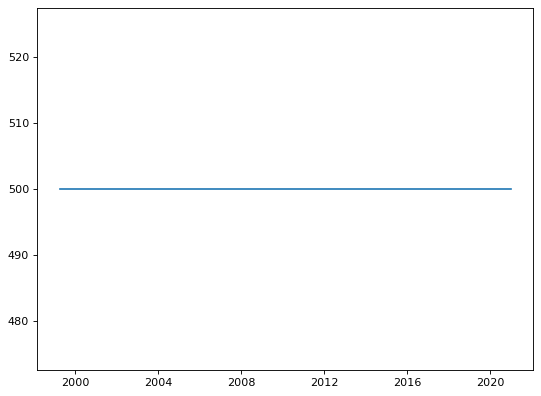

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Calculate the number of funds over time
data['Counts'] = np.ones(len(data))
fundcount = data.groupby(['Date']).count()

display(fundcount['Counts'])

# Plot count over time
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fundcount.index, fundcount['Counts'])
plt.show()

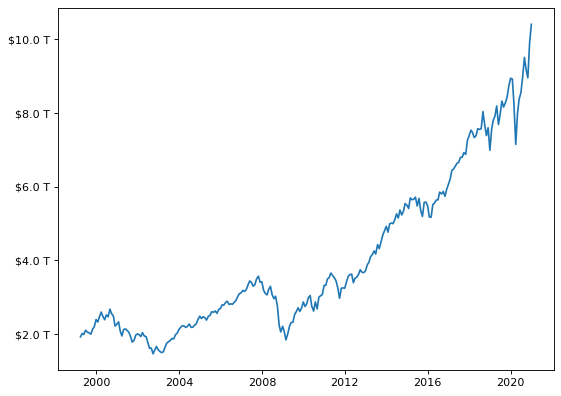

In [3]:
from matplotlib.ticker import FuncFormatter

# Calculate the number of assets over time
fundassets = data.groupby(['Date']).sum()

# Assets under management are in millions. Adjust the data accordingly.
fundassets['mtna'] = fundassets['mtna'] * (10**6)

# Plot assets over time
fig = figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fundassets.index, fundassets['mtna'])

# Show y-axis in trillions
# https://stackoverflow.com/questions/61330427/set-y-axis-in-millions
def millions(x, pos):
    return '$%1.1f T' % (x * 1e-12)

formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

# Calculate (some random) descriptive statistics

In [4]:
# Specify which statistic to calculate
descriptive = data.agg({
    "mtna": ["min", "max", "median", "skew"],
    "mret": ["min", "max", "median", "skew"],
    "mnav": ["min", "max", "median", "skew"],
    "turn_ratio": ["min", "max", "median", "skew"],
})
print(descriptive)
print('\n')

# Or, use describe
descriptive = data[['mtna', 'mret', 'mnav', 'turn_ratio']].describe().apply(lambda s: s.apply('{0:.2f}'.format))
print(descriptive)

                 mtna       mret        mnav  turn_ratio
min        650.800000  -0.882336    1.000000    0.000000
max     359552.800000   6.033279  619.340000   14.130000
median    3992.100000   0.010516   26.850000    0.310000
skew         8.001931  18.418456    3.472116    9.316728


            mtna       mret       mnav turn_ratio
count  131000.00  131000.00  130995.00  117441.00
mean     8062.00       0.01      39.46       0.49
std     15840.71       0.06      39.99       0.75
min       650.80      -0.88       1.00       0.00
25%      2110.40      -0.02      16.60       0.14
50%      3992.10       0.01      26.85       0.31
75%      7558.40       0.04      44.97       0.62
max    359552.80       6.03     619.34      14.13


# Load the Fama-French series

In [6]:
#  Load the 5 Factor into dataframe
famafrench = pd.read_csv('F-F_Research_Data_5_Factors_2x3.CSV', index_col=0, skiprows=3)

#  Load the 5 Factor into dataframe
momentum = pd.read_csv('F-F_Momentum_Factor.CSV', skiprows=13, index_col=0)

# Left-join the momentum dataframe to the famafrench dataframe
famafrench = famafrench.merge(momentum, left_index=True, right_index=True, how='left')

# Rename the momentum column to "WML"
famafrench.rename(columns={"Mom":"WML"}, inplace=True)

# Make returns into decimals instead of percentages
famafrench = famafrench / 100
display(famafrench)

,Mkt-RF,SMB,HML,RMW,CMA,RF,WML
196307,-0.0039,-0.0045,-0.0094,0.0066,-0.0115,0.0027,0.0100
196308,0.0507,-0.0082,0.0182,0.0040,-0.0040,0.0025,0.0103
196309,-0.0157,-0.0048,0.0017,-0.0076,0.0024,0.0027,0.0016
196310,0.0253,-0.0130,-0.0004,0.0275,-0.0224,0.0029,0.0314
196311,-0.0085,-0.0085,0.0170,-0.0045,0.0222,0.0027,-0.0075
...,...,...,...,...,...,...,...
202008,0.0763,-0.0094,-0.0294,0.0427,-0.0144,0.0001,0.0051
202009,-0.0363,0.0007,-0.0251,-0.0115,-0.0177,0.0001,0.0305
202010,-0.0210,0.0476,0.0403,-0.0060,-0.0053,0.0001,-0.0303
202011,0.1247,0.0675,0.0211,-0.0278,0.0105,0.0001,-0.1225


### Fama-French cumulative return plot (after 2000)

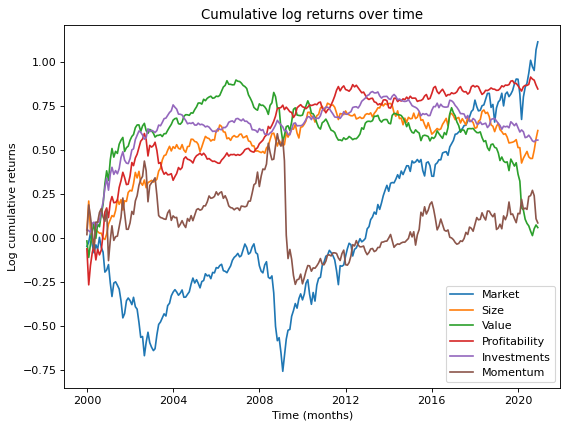

In [7]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# Get sample period
famafrench_sample = famafrench[famafrench.index > 199912]

# Calculate cumulative returns on the dataframe
#famafrench_cumprod = np.cumprod(1 + famafrench_sample, axis=0) - 1   # Cumulative ARITHMETIC returns
famafrench_cumprod = np.cumsum(np.log(1 + famafrench_sample), axis=0)  # Cumulative LOG returns

# Add Python datetime to the dataframe (new column called "Date")
famafrench_cumprod['Date'] = pd.to_datetime(famafrench_sample.index, format="%Y%m")

# Plot the cumulative fama-french factors over time
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(famafrench_cumprod['Date'], famafrench_cumprod[['Mkt-RF','SMB','HML','RMW','CMA','WML']])
plt.title('Cumulative log returns over time')
plt.legend(['Market','Size','Value','Profitability','Investments','Momentum'])
plt.xlabel('Time (months)')
plt.ylabel('Log cumulative returns')
plt.show()

### Fama-French factors statistics (using _scikit-learn.linear_model_)

In [8]:
import sklearn.linear_model as lm

# Get sample period
ff_sample = famafrench[famafrench.index > 198912]

# Initialize results
cols = ["Avg returns", "Volatility", "Sharpe ratio", "Alpha", "Beta"]
results = pd.DataFrame(data=None, index=famafrench.columns, columns=cols)

# Calculate average returns
results["Avg returns"] = ff_sample.mean() * 12

# Calculate volatility of returns
results["Volatility"] = ff_sample.std() * np.sqrt(12)

# Calculate Sharpe ratio
results["Sharpe ratio"] = (ff_sample.mean() * 12) / (ff_sample.std() * np.sqrt(12))

# Specify type of model
reg = lm.LinearRegression()

print('\n\nThe regression results are:\n')

# Loop over each factor
for factor in ['SMB','HML','RMW','CMA','WML']:
    
    x = ff_sample['Mkt-RF'].values.reshape(ff_sample.shape[0], 1)
    y = ff_sample[factor].values.reshape(ff_sample.shape[0], 1)
    
    # Fit regression
    reg.fit(x, y)
    
    # Save alpha
    results.loc[factor, "Alpha"] = reg.intercept_[0] * 12
    
    # Save beta
    results.loc[factor, "Beta"] = reg.coef_[0][0]
    
    # Print results
    print("> For factor {}, intercept = {:.2f} and beta = {:.2f}".format(factor, reg.intercept_[0], reg.coef_[0][0]))

# Only keep results for relevant factors
results = results.loc[['Mkt-RF','SMB','HML','RMW','CMA','WML'], :]

# Print final results
print('\n\nThe final results are (all numbers annualized):')
display(results)
display(results.T)



The regression results are:

> For factor SMB, intercept = 0.00 and beta = 0.17
> For factor HML, intercept = 0.00 and beta = -0.08
> For factor RMW, intercept = 0.00 and beta = -0.21
> For factor CMA, intercept = 0.00 and beta = -0.17
> For factor WML, intercept = 0.01 and beta = -0.31


The final results are (all numbers annualized):


,Avg returns,Volatility,Sharpe ratio,Alpha,Beta
Mkt-RF,0.085735,0.152197,0.563318,NaN,NaN
SMB,0.016858,0.105802,0.159336,0.00200066,0.173294
HML,0.006084,0.106307,0.057229,0.0127636,-0.0779104
RMW,0.038845,0.089233,0.435324,0.0569746,-0.211457
CMA,0.019429,0.070887,0.274084,0.0336119,-0.165426
WML,0.058432,0.164925,0.354295,0.0846169,-0.305412


,Mkt-RF,SMB,HML,RMW,CMA,WML
Avg returns,0.0857355,0.0168581,0.00608387,0.0388452,0.019429,0.0584323
Volatility,0.152197,0.105802,0.106307,0.0892328,0.0708872,0.164925
Sharpe ratio,0.563318,0.159336,0.057229,0.435324,0.274084,0.354295
Alpha,NaN,0.00200066,0.0127636,0.0569746,0.0336119,0.0846169
Beta,NaN,0.173294,-0.0779104,-0.211457,-0.165426,-0.305412


# Adding new variables to the mutual funds based on rolling windows

### Calculating the 3-year alpha, market beta, HML beta and 12-month returns for each fund at each month

In [10]:
from tqdm.notebook import trange, tqdm
import sklearn.linear_model as lm

# Initialize list that is going to keep track of all our results
# I'm using a list here because that is the fastest object in Python!
# I also tried to directly save the results to the 'data' dataframe inside of the loops but that was 4x slower.
results = []

# Specify type of model
reg = lm.LinearRegression()

# Get the string representation of the months starting in 1992
dates = famafrench.index[famafrench.index >= 199200].unique()

# Starting index
lookback = 36     # Lookback period is 36 months (3 years)

# Loop over the dates
for period in trange(lookback, len(dates)):
    
    # Get the current date
    current_date = dates[period]
    
    # Get all dates of 36 months ago until last month
    lookback_period = dates[period-lookback:period]
    
    # Print some information
    print('Iteration {} at date {}, lookback period is {} to {} ({:.0f} months)'.format(
        period, current_date, lookback_period[0], lookback_period[-1], len(lookback_period)))

    # Get corresponding Fama-French data
    ff_history_index = famafrench.index.isin(lookback_period)
    ff_history = famafrench.loc[ff_history_index]
    
    # Get all funds at this period in time (in this iteration)
    funds_this_period_index = data.index.get_level_values('YYYYMM') == current_date
    funds_this_period = data.loc[funds_this_period_index, 'crsp_fundno'].unique()
    
    # Get all historical data for the funds that exist in this period in time
    funds_historical_data_index = np.logical_and(
        data.index.get_level_values('YYYYMM').isin(lookback_period),
        data.index.get_level_values('crsp_fundno').isin(funds_this_period)
    )
    funds_historical_data = data.loc[funds_historical_data_index]
    
    # Loop over all funds THIS PERIOD
    for fund in funds_this_period:
        
        # Get the row positions for the data for this fund   
        fund_data_index = funds_historical_data.index.get_level_values('crsp_fundno') == fund
        
        # Get the individual data for this fund
        # And make new index that corresponds to the ff_history index (this makes the merge below faster!)
        fund_data = funds_historical_data.loc[fund_data_index].set_index('YYYYMM')
        
        # If this specific fund has less than 25 observations, ignore it!
        if fund_data.shape[0] < 25:
            continue
        
        # Join the regression data together
        reg_data = ff_history.merge(fund_data['mret'], left_index=True, right_index=True, how='left')
        
        # Calculate the fund returns over the previous 12 months
        ret_12_months = np.product(1 + reg_data.tail(12)['mret']) - 1
        
        # Remove rows with no data
        reg_data = reg_data.dropna()
        
        # Calculate excess returns for the fund
        reg_data['Excess fund return'] = reg_data['mret'] - reg_data['RF']
            
        # Get the x-values for the regression
        x = reg_data[['Mkt-RF','HML']].values.reshape(reg_data.shape[0], 2)
        
        # Get the y-values for the regression
        y = reg_data['Excess fund return'].values.reshape(reg_data.shape[0], 1)
        
        # Fit regression
        reg.fit(x, y)
        
        # Append the calculations to our 'results' list
        # Note that the order in which we save the results matters! (see comment with [!!!] at the bottom of this code)
        
        #                 YYYYMM   crsp_fundno     Alpha        Market beta        HML beta        12M return
        #                    v          v            v               v                v                v
        #                    v          v            v               v                v                v
        results.append([current_date, fund, reg.intercept_[0], reg.coef_[0][0], reg.coef_[0][1], ret_12_months])
        

# This is the end of the loops

# We now turn our 'results' list into a dataframe (so we can merge it with the 'data' dataframe below)
# [!!!] Note that we need to specify the order of the results using (the correct) column names
results = pd.DataFrame(results, columns=['YYYYMM','crsp_fundno','Alpha','Market beta','HML beta','12M return'])

# Create multi-index (so it matches the 'data' dataframe index)
results.set_index(['YYYYMM','crsp_fundno'], inplace=True)

# Final step: merge our results back into the original 'data' dataframe. The matching is done based on the multi-index!
data = data.merge(results, left_index=True, right_index=True, how='left')

# DONE! 
# We just added new data to each fund at each moment in time based on historical (36-month) regressions!

print('Done.')

Iteration 36 at date 199501, lookback period is 199201 to 199412 (36 months)
Iteration 37 at date 199502, lookback period is 199202 to 199501 (36 months)
Iteration 38 at date 199503, lookback period is 199203 to 199502 (36 months)
Iteration 39 at date 199504, lookback period is 199204 to 199503 (36 months)
Iteration 40 at date 199505, lookback period is 199205 to 199504 (36 months)
Iteration 41 at date 199506, lookback period is 199206 to 199505 (36 months)
Iteration 42 at date 199507, lookback period is 199207 to 199506 (36 months)
Iteration 43 at date 199508, lookback period is 199208 to 199507 (36 months)
Iteration 44 at date 199509, lookback period is 199209 to 199508 (36 months)
Iteration 45 at date 199510, lookback period is 199210 to 199509 (36 months)
Iteration 46 at date 199511, lookback period is 199211 to 199510 (36 months)
Iteration 47 at date 199512, lookback period is 199212 to 199511 (36 months)
Iteration 48 at date 199601, lookback period is 199301 to 199512 (36 months)

# Creating a strategy based on mutual funds ("rank portfolios")
### The idea is simple: once a year we select the mutual funds with the highest return over the previous year. We then buy those mutual funds (equally-weighted) and hold onto them for a year. We then "rebalance" by repeating the procedure (selecting the new best funds), hold onto them for a year, etc.

In [16]:
# Settings
lookforward = 12               # Evaluation period is 12 months (one year into the future)
rebalance = lookforward        # Rebalancing frequency is equal to lookforward period (every 12 months)
number_quantiles = 10          # Number of quantile portfolios to create. For this example we will create DECILES.
rank_variable = '12M return'   # Characteristic on which funds will be sorted into quantiles

# Get the string representation of the months starting in December 1992 (first rebalancing moment)
dates = famafrench.index[famafrench.index >= 199212].unique()

# Initialize results
quantile_portfolios = pd.DataFrame(data=None, index=dates, columns=range(0, number_quantiles))

# Loop over the dates
for period in trange(0, len(dates), rebalance):

    # Get the current date
    current_date = dates[period]
    
    # Get all dates of the next year (lookforward window)
    lookforward_period = dates[period+1:period+lookforward+1]
    
    # Assign a cumulative number for each period in the future (so we can group by this later)
    quantile_portfolios_index = quantile_portfolios.index.isin(lookforward_period)
    quantile_portfolios.loc[quantile_portfolios_index, 'Holding period'] = range(1, len(lookforward_period)+1)
    
    # Get all funds at this period in time (in this iteration)
    funds_this_period_index = data.index.get_level_values('YYYYMM') == current_date
    funds_this_period = data.loc[funds_this_period_index]
    
    # If less than 100 funds in total, ignore the code below
    if funds_this_period[rank_variable].count() < 100:
        continue
    
    # Sort the funds into quantiles (using pandas 'qcut' function)
    quantiles_index = pd.qcut(funds_this_period[rank_variable], number_quantiles, labels=range(0, number_quantiles))
    
    # Loop over each quantile
    for q in range(0, number_quantiles):
        
        # Get the fund identifiers that are part of this quantile
        funds_in_quantile = quantiles_index.index.get_level_values('crsp_fundno')[quantiles_index == q]
        
        # Get the forward-looking returns of the funds that belong to this quantile
        fund_returns_index = np.logical_and(
            data.index.get_level_values('YYYYMM').isin(lookforward_period),
            data.index.get_level_values('crsp_fundno').isin(funds_in_quantile)
        )
        fund_returns = data.loc[fund_returns_index, 'mret']
        
        # Put the dates as columns (instead of having a multi-column index, make separate columns for each date)
        fund_returns = fund_returns.unstack(level='YYYYMM')
        
        # Define the weighting scheme.
        # For now, we will created equally-weighted quantile portfolios.
        # We assume that if a mutual fund closes, we can reinvest our redeemed money in the remaining funds.
        fund_weights = fund_returns.notna().astype(int)
        fund_weights = fund_weights.div(fund_weights.sum(axis=0), axis=1)
        
        # Multiply returns with weights to get the return of the quantile portfolio
        quantile_portfolio_return = (fund_returns * fund_weights).sum(axis=0, skipna=True)
        
        # Save the future returns for this quantile in the 'quantile_portfolios' dataframe
        quantile_portfolios_index = quantile_portfolios.index.isin(lookforward_period)
        quantile_portfolios.loc[quantile_portfolios_index, q] = quantile_portfolio_return
        
print('Quantile portfolios are created.')


Quantile portfolios are created.


### Plot cumulative returns of quantile portfolios

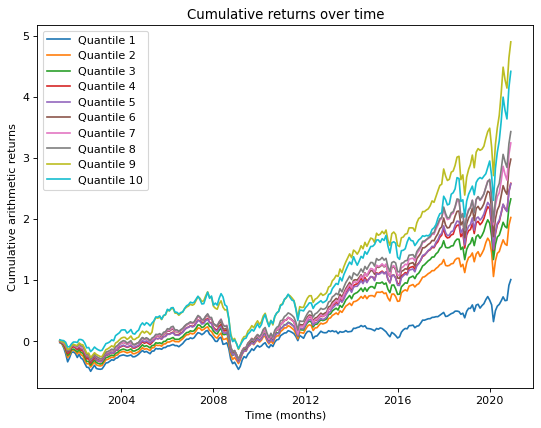

In [17]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# Calculate cumulative log returns of quantile portfolios
quantile_portfolios_cumprod = np.cumprod(1 + quantile_portfolios, axis=0) - 1

# Add Python datetime to the dataframe (new column called "Date")
quantile_portfolios_cumprod['Date'] = pd.to_datetime(quantile_portfolios_cumprod.index, format="%Y%m")

# Plot the cumulative fama-french factors over time
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(quantile_portfolios_cumprod['Date'], quantile_portfolios_cumprod[range(0,number_quantiles)])
plt.title('Cumulative returns over time')
plt.legend(["Quantile {}".format(q) for q in range(1,number_quantiles+1)])
plt.xlabel('Time (months)')
plt.ylabel('Cumulative arithmetic returns')
plt.show()

### Plot holding-period return for each quantile
_Edit: this plot now works for any holding period_

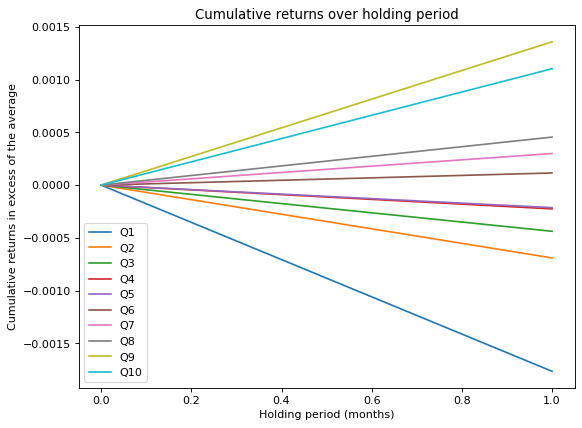

In [18]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# Get the string representation of the months starting in December 1992 (first rebalancing moment)
dates = famafrench.index[famafrench.index >= 199212].unique()

# Because portfolios are rebalanced every December, we can simply keep track of the return in each month
portfolio_returns = quantile_portfolios.copy()

# Calculate the average returns per portfolio, per month
returns_per_month = portfolio_returns.fillna(0).groupby(['Holding period']).mean()

# Calculate the holding-period cumulative return
holding_returns = np.cumprod(1 + returns_per_month, axis=0) - 1

# Add a column with the average return per holding period
holding_returns['Average'] = holding_returns.mean(axis=1)

# For each fund, subtract the average return
for q in range(0,number_quantiles):
    holding_returns[q] = holding_returns[q] - holding_returns['Average']
    
# Plot the cumulative fama-french factors over time
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(holding_returns.index, holding_returns[range(0, number_quantiles)])
plt.title('Cumulative returns over holding period')
plt.legend(["Q{}".format(q) for q in range(1, number_quantiles+1)], loc='lower left')
plt.xlabel('Holding period (months)')
plt.ylabel('Cumulative returns in excess of the average')
plt.show()

### Quantile portfolio statistics

In [19]:
import numpy as np
import statsmodels.api as sm

# Specify portfolios to analyze
portfolios = quantile_portfolios

# Load Fama-French factors
ff = famafrench[famafrench.index.isin(portfolios.index)]

# Merge together
portfolios = portfolios.merge(ff, left_index=True, right_index=True, how='left')

# Initialize results
cols = ["Avg returns", "Avg excess returns", "Volatility", "Sharpe ratio", "Alpha", "Std. error (α)", "t-stat (α)", "p-value (α)", "Beta"]
results = pd.DataFrame(data=None, index=portfolios.columns, columns=cols)

# Calculate average returns
results["Avg returns"] = portfolios.mean() * 12
results.loc[:, "Avg excess returns"] = results.loc[:, "Avg returns"] - results.loc["RF", "Avg returns"]

# Calculate volatility of returns
results["Volatility"] = portfolios.std() * np.sqrt(12)

# Calculate Sharpe ratio
results["Sharpe ratio"] = results["Avg excess returns"] / results["Volatility"]

# Loop over each portfolio
for quantile in range(0, number_quantiles):
    
    # Find index of available data
    index = portfolios[q].notna()
    
    # Get x and y variables
    x = portfolios.loc[index, 'Mkt-RF'].astype(float)
    y = portfolios.loc[index, quantile].astype(float) - portfolios.loc[index, 'RF']
    
    # Note! Need to add intercept myself using this syntax
    x = sm.add_constant(x)
    
    # Fit regression
    model = sm.OLS(y, x).fit()   # Note! y and x are passed to this function in reverse order. It differs per package!
    
    # Save alpha
    results.loc[quantile, "Alpha"] = model.params[0] * 12
    
    # Save standard error of the alpha
    results.loc[quantile, "Std. error (α)"] = model.bse[0]
    
    # Save tstat of the alpha
    results.loc[quantile, "t-stat (α)"] = model.tvalues[0]
    
    # Save p-value of the alpha
    results.loc[quantile, "p-value (α)"] = model.pvalues[0]
    
    # Save beta
    results.loc[quantile, "Beta"] = model.params[1]

# Only keep results for relevant factors
results = results.loc[range(0, number_quantiles)]
results.index = ["Q{}".format(q) for q in range(1, number_quantiles+1)]

# Print final results
print('\n\nThe final results are (all numbers annualized):')
display(results.T)



The final results are (all numbers annualized):


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
Avg returns,0.0499011,0.068262,0.0725788,0.0762041,0.076406,0.0820189,0.085171,0.0878314,0.103254,0.0989
Avg excess returns,0.0268447,0.0452057,0.0495225,0.0531477,0.0533497,0.0589625,0.0621147,0.064775,0.080198,0.0758436
Volatility,0.168382,0.152938,0.149146,0.14818,0.149897,0.151198,0.150157,0.153348,0.158857,0.15829
Sharpe ratio,0.159428,0.295581,0.332039,0.358671,0.355909,0.389969,0.413664,0.422406,0.504843,0.479143
Alpha,-0.0453586,-0.0237736,-0.0184884,-0.014843,-0.015749,-0.0110137,-0.00720296,-0.00587197,0.00932508,0.007899
Std. error (α),0.00127274,0.000703855,0.000521974,0.000415396,0.000368586,0.000313468,0.000343065,0.000444596,0.000877148,0.00114126
t-stat (α),-2.96988,-2.81469,-2.95168,-2.97769,-3.56068,-2.92792,-1.74966,-1.10062,0.885928,0.576775
p-value (α),0.00328932,0.00529818,0.00348206,0.00320968,0.00044797,0.00374908,0.0814886,0.272193,0.376566,0.564646
Beta,1.00724,0.967822,0.955982,0.955737,0.969281,0.98001,0.971958,0.98821,0.990972,0.955173


---

# That's it. Now it's up to you to study the code and practice with it!

In [17]:
"""
  ____        _   _                   _                                                    
 |  _ \ _   _| |_| |__   ___  _ __   (_)___    __ ___      _____  ___  ___  _ __ ___   ___ 
 | |_) | | | | __| '_ \ / _ \| '_ \  | / __|  / _` \ \ /\ / / _ \/ __|/ _ \| '_ ` _ \ / _ \
 |  __/| |_| | |_| | | | (_) | | | | | \__ \ | (_| |\ V  V /  __/\__ \ (_) | | | | | |  __/
 |_|    \__, |\__|_| |_|\___/|_| |_| |_|___/  \__,_| \_/\_/ \___||___/\___/|_| |_| |_|\___|
        |___/                                                                              
        
"""
print('End of notebook.')

End of notebook.


---